In [1]:
struct Models
    # parameters
    β::Float64 # discount factor
    γ::Float64 # relative risk aversion
    
    # factor price
    rent::Float64 # net interest rate
    
    # grid
    nw::Int64 # the number of income grid
    w_max::Float64 # the maximum value of income grid
    w_min::Float64 # the minimum value of income grid
    grid_w::Vector{Float64} # income grid
end

In [2]:
function Calibration()
    # set parameters here
    β = 0.985^30
    γ = 2.0
    rent = 1.025^30 - 1.0
    nw = 10
    w_max = 1.0
    w_min = 0.1

    grid_w = collect(LinRange(w_min, w_max, nw))

    return Models(β, γ, rent, nw, w_max, w_min, grid_w)
end

Calibration (generic function with 1 method)

In [3]:
function CRRA(cons::Float64, γ::Float64)
    if γ != 1.0
       return cons^(1.0-γ) / (1.0-γ) 
    else
       return log(cons)
    end
end

CRRA (generic function with 1 method)

In [10]:
# Load the required packages
using Plots
# pyplot()
using Optim # A Julia's Optimization Tool: There are many others

# Control variable is continuous: Optimization
<!-- # 操作変数を連続変数にする：最適化 -->

- The approach that discretizes both state and control variables has very poor approximation when we save the number of discretized grid points
<!-- - 状態変数と操作変数をともに離散化するアプローチは、離散化するグリッドの数を節約すると精度が非常に悪くなる -->

- The true solution of Eq. (4) is linear, but the saving function with $J=40$ is not linear
<!-- - 本来の解である(4)式は線形であるはずなのに、$J=40$のときの貯蓄関数は直線ではない -->

- We consider a little bit more sophisticated approach: The state variable are discretized whereas the control variable takes continuous values
<!-- - そこで、もう少し洗練されたアプローチを考える：状態変数は離散化するが、操作変数については連続的な値をとる -->

- The utility miaximization problem of an economic agent, regarding each $w_{i}$ for $i=1,\dots,I$, solves
<!-- - 経済主体の最適化問題は、各$w_{i}$ for $i=1,\dots,I$について、 -->

$$
  \max_{a} \frac{[w_{i}-a]^{1-\gamma}}{1-\gamma}+\beta\frac{[(1+r)-a]^{1-\gamma}}{1-\gamma} \tag{6}
$$

where the control variable $a\in\mathbb{R}$ can take any real number
<!-- となるが、操作変数$a\in\mathbb{R}$については任意の実数をとりうる -->

In [5]:
function obj_two_period(a::Float64, w_val::Float64, params::Models)

    # Utility in the first period
    if w_val - a > 0.0 # Note that utility cannot be calculated unless c=w-a>0
        util_y = CRRA(w_val - a, params.γ)
    else
        util_y = -1000000.0 # Penalty for negative consumption
    end

    # Discounted utility in the second period
    util_o = params.β*CRRA((1.0 + params.rent)*a, params.γ)
    
    # Julia's optimize finds the minimum, so multiply -1.0 to obtain the maximum
    return  -1.0*(util_y + util_o)

end

obj_two_period (generic function with 1 method)

- How to get the solution of Eq. (6)?
<!-- - どうやって(6)式の解を得ればよいのであろうか？ -->

- For now, use the library called optimization
<!-- - とりあえず、最適化(optimization)と呼ばれるライブラリを使う -->
    - For MATLAB, fminsearch and fminbnd in Optimization Toolbox
    - For Python, fmin in Scipy
    - For Julia, functions in Optim.jl
<!--     - MATLABであれば、Optimization Toolboxにある関数fminsearchやfminbnd -->
<!--     - Pythonであれば、SciPyにある関数fmin -->
<!--     - Juliaであれば、Optim.jlにある関数 -->

- Algorithm
<!-- - アルゴリズム -->

1. Set parameters (calibration)

2. Let $w_{i}\in\{w_{1},\dots,w_{I}\}$ be the discretized income in the young period

3. Find $a$ such that maximizes (6) for each $w_{i}$ using optimization function in each language

4. The obtained combination of $w_{i}$ and $a$ is the saving function

<!-- 1. パラメータを設定する（カリブレーション）。

2. $w_{i}\in\{w_{1},\dots,w_{I}\}$を離散化した若年期の所得とする。

3. 各$w_{i}$について、(6)式を最大にするような$a$を探し出す。各言語の最適化関数を利用する。

4. 得られた各$w_{i}$と$a$の組み合わせが貯蓄関数である。 -->

In [11]:
# Put parameters set beforehand together into a variable params
params = Calibration()

# Prepare empty variables
a_gs = zeros(params.nw)

# Find the saving level a such that maximizes the objective function for each w
for i = 1:params.nw

    w_val = params.grid_w[i]

    # "Redefine" function obj_two_period
    # Make a function which has a as the only argument: Function inside optimize must be the original function with given parameters
    obj_two_period!(a) = obj_two_period(a, w_val, params)

    # Calculate by Golden Section Search
    # Usage: Indicate the range to find the optimal value of a, [w_val*0.01, w_val*2.0]
    # An algorithm to find a to minimize (maximize) the function within the range
    res = optimize(obj_two_period!, w_val*0.01, w_val*2.0, GoldenSection())

    a_gs[i] = res.minimizer
end

print(a_gs)

[0.035500888178047925, 0.07100177635609585, 0.10650266453414378, 0.1420035527121917, 0.17750444089023965, 0.21300532906828756, 0.24850621724633548, 0.2840071054243834, 0.3195079857755279, 0.3550088817804793]

- Figure shows the saving function plotted by finding the optimal $a$ for each $w_{i}$. This approach has better approximation by making the control variable continuous 
<!-- - 図は、Pythonの最適化関数scipy.optimize.fminboundを使って、各$w_{i}$における最適な$a$を探してプロットした貯蓄関数。操作変数が取りうる値を連続にすることで、計算精度が大幅に改善された。 -->

In [12]:
# Analytical solution: Eq. (2.4)
coef1 = (params.β*(1.0 + params.rent))^(-1.0/params.γ)
coef2 = 1.0/(1.0+coef1*(1.0 + params.rent))
a_cfs = coef2*params.grid_w

10-element Vector{Float64}:
 0.03550088777115455
 0.0710017755423091
 0.10650266331346364
 0.1420035510846182
 0.17750443885577274
 0.21300532662692728
 0.24850621439808182
 0.2840071021692364
 0.3195079899403909
 0.3550088777115455

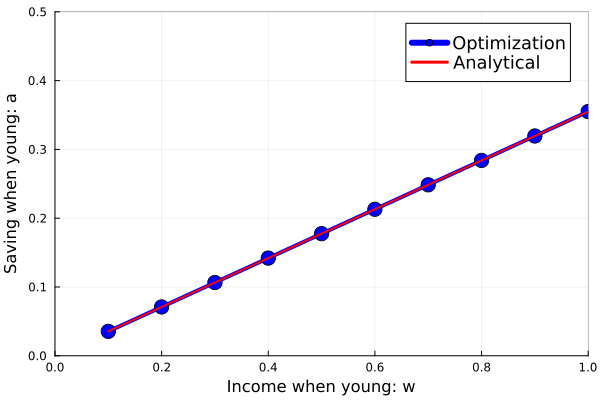

In [16]:
# Replicate figure 2.2
plt = plot(params.grid_w, a_gs,
    color = :blue,
    marker = :circle,
    legend = :topright,
    xlims = (0, 1.0),
    ylims = (0, 0.5),
    label = ("Optimization"),
    xlabel = ("Income when young: w"),
    ylabel = ("Saving when young: a"),
    linewidth = 4,
    markersize = 8,
#     titlefont = font("HackGen35Nerd", 12),
#     guidefont = font("HackGen35Nerd", 12),
#     tickfont = font("HackGen35Nerd", 8),
#     legend_font_family = ("HackGen35Nerd"),
    legendfontsize = 12,
    framestyle = :semi
)
plot!(params.grid_w, a_cfs, linewidth = 2, color = :red, label="Analytical")